## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [0]:
# Imports
from statistics import *
import pandas as pd
import numpy as np
from scipy.stats import t, ttest_1samp
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# Specify the columns for the UCI dataset
cols = [
    'party',
    'handicapped-infants',
    'water-project',
    'budget',
    'physician-fee-freeze',
    'el-salvador-aid',
    'religious-groups',
    'anti-satellite-ban',
    'aid-to-contras',
    'mx-missile',
    'immigration',
    'synfuels',
    'education',
    'right-to-sue',
    'crime',
    'duty-free',
    'south-africa',
    ]


# Assign the url string to a variable
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'

# Fetch the csv data assuming no header row in the data"
#   1. assign the column names specified above
#   2. replace '?' with NaN values
df_house = pd.read_csv(url, header=None, names=cols, na_values='?')

# Translate 'y' and 'n' votes to numeric '1' and'0'
df_house = df_house.replace({'y': 1, 'n': 0})


In [189]:
# Calculate the mean vote for each issue across the house
dct_vote_means = {}
for i in range(1, len(cols)):
  # Grab the vote data into a series
  seris_tmp = df_house[cols[i]]

  # Remove nas from the series
  seris_tmp = seris_tmp.dropna()

  # Assign the "mean" vote to a dict for use downstream
  dct_vote_means[cols[i]] = seris_tmp.mean()

dct_vote_means

{'aid-to-contras': 0.5761904761904761,
 'anti-satellite-ban': 0.5676959619952494,
 'budget': 0.5966981132075472,
 'crime': 0.5933014354066986,
 'duty-free': 0.4275184275184275,
 'education': 0.42326732673267325,
 'el-salvador-aid': 0.5047619047619047,
 'handicapped-infants': 0.44208037825059104,
 'immigration': 0.5046728971962616,
 'mx-missile': 0.5012106537530266,
 'physician-fee-freeze': 0.41745283018867924,
 'religious-groups': 0.6415094339622641,
 'right-to-sue': 0.5097560975609756,
 'south-africa': 0.8126888217522659,
 'synfuels': 0.36231884057971014,
 'water-project': 0.5038759689922481}

In [0]:
# Set up some "constants"
num_samples     = 10
num_sample_size = 20

In [0]:
# sample_me returns a list of means of house vote samples for use downstream
#    issue: the issue being voted on
#    num: number of samples to be taken
#    size: sample size (# of votes in sample)
def sample_me(issue, num, size):
  # Set up working variables
  rt_list = [] # return a list of means

  # Generate a series of the issue's votes
  srs_tmp = df_house[issue]
  # Drop nas from the series votes
  srs_tmp = srs_tmp.dropna()

  # Number of votes on this issue
  tot_vts = len(srs_tmp)

  # Iterate to create 'num' sample means
  for i in range(1, num+1):
    # Randomly select a sample of 'size'
    smpl_iter = srs_tmp.sample(n=size)

    # Generate the mean of the sample
    tmp_mean = smpl_iter.mean()

    # Add the mean to our return list
    rt_list.append(tmp_mean)
  
  # Return the temp series and list of sample means
  return {"means": rt_list, "series": srs_tmp}
   

In [0]:
def gen_conf_intvls(issue):
  # Generate 10 samples of 20 votes of issue 'issue'
  rslts_sample = sample_me(issue, num_samples, num_sample_size)

  tmp_means = rslts_sample["means"]
  # Determine the sample size
  n = len(tmp_means)

  # Determine the 'degrees of freedom'
  dof = n - 1

  # Calculate the mean of the sample means
  sample_mean = mean(tmp_means)

  # Calculate the standard deviation of the sample means
  sample_std = np.std(tmp_means, ddof=1)

  # Calclate the standard error of the sample means
  sample_std_err = sample_std/(n**.5)

  # Generate the confidence interval
  conf_int = t.interval(.95, dof, loc=sample_mean, scale=sample_std_err)

  # Return output
  return {"lower": conf_int[0], "mean": sample_mean, "upper": conf_int[1], "list_means": tmp_means}


In [0]:
# Iterate through our issues
lst_datfrm = []     # list of issue confidence intervals

for i in range(1, len(cols)):
  # Generate the confidence interval 
  tmp_rslts = gen_conf_intvls(cols[i])

  # Construct a dataframe row for use downstream

  # Start with adding the issue, CI lower bound, mean, and CI upper bound
  tmp_row = [cols[i], tmp_rslts["lower"], tmp_rslts["mean"], tmp_rslts["upper"]]

  # Then add the sample means
  for i in range(0, len(tmp_rslts["list_means"])):
    tmp_row.append(tmp_rslts["list_means"][i])

  # Append to a working list of rows which will (ultimately) make up our dataframe
  lst_datfrm.append(tmp_row) 


In [0]:
# Create a dataframe of confidence interval results
df_cols = ['Issue', 'LowerBound', 'Mean', 'UpperBound']
for i in range(1, num_samples+1):
  df_cols.append(int(i))

df_issue_CIs = pd.DataFrame(lst_datfrm, columns=df_cols)

In [195]:
df_issue_CIs

,Issue,LowerBound,Mean,UpperBound,1,2,3,4,5,6,7,8,9,10
0,handicapped-infants,0.366425,0.460,0.553575,0.35,0.30,0.35,0.50,0.35,0.60,0.60,0.35,0.60,0.60
1,water-project,0.388786,0.470,0.551214,0.35,0.55,0.45,0.75,0.40,0.45,0.40,0.45,0.40,0.50
2,budget,0.491591,0.550,0.608409,0.40,0.55,0.65,0.45,0.55,0.60,0.50,0.60,0.65,0.55
3,physician-fee-freeze,0.354263,0.420,0.485737,0.30,0.30,0.50,0.55,0.50,0.45,0.50,0.35,0.35,0.40
4,el-salvador-aid,0.413365,0.485,0.556635,0.70,0.50,0.45,0.55,0.45,0.35,0.40,0.40,0.50,0.55
5,religious-groups,0.613101,0.690,0.766899,0.65,0.70,0.70,0.70,0.75,0.65,0.45,0.65,0.85,0.80
6,anti-satellite-ban,0.529676,0.590,0.650324,0.65,0.70,0.65,0.55,0.65,0.60,0.55,0.40,0.60,0.55
7,aid-to-contras,0.502366,0.580,0.657634,0.55,0.55,0.80,0.45,0.50,0.70,0.65,0.50,0.60,0.50
8,mx-missile,0.421627,0.505,0.588373,0.70,0.55,0.55,0.50,0.40,0.50,0.50,0.55,0.25,0.55
9,immigration,0.426614,0.495,0.563386,0.50,0.40,0.60,0.50,0.60,0.50,0.60,0.50,0.30,0.45



Issue - handicapped-infants: Confidence Interval:
0.36642455958147885 => Mean: 0.45999999999999996 => 0.553575440418521



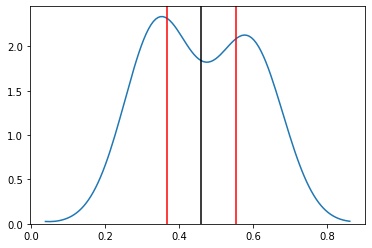


Compared to the actual vote (0.44208037825059104) the random samples t-test results in:
t Statistic: 0.433201281369671 p-value: 0.6750653921665393

-----

Issue - water-project: Confidence Interval:
0.3887860723933332 => Mean: 0.47000000000000003 => 0.5512139276066669



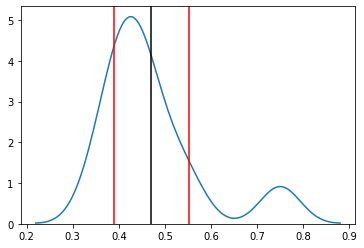


Compared to the actual vote (0.5038759689922481) the random samples t-test results in:
t Statistic: -0.9435914277136235 p-value: 0.37001771084811697

-----

Issue - budget: Confidence Interval:
0.49159135321466885 => Mean: 0.55 => 0.6084086467853312



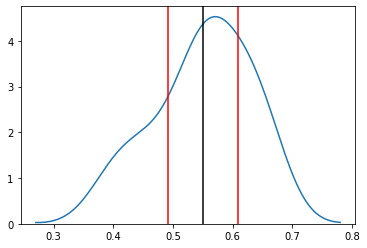


Compared to the actual vote (0.5966981132075472) the random samples t-test results in:
t Statistic: -1.8086101475213865 p-value: 0.1039635263251712

-----

Issue - physician-fee-freeze: Confidence Interval:
0.35426323688803546 => Mean: 0.42 => 0.4857367631119645



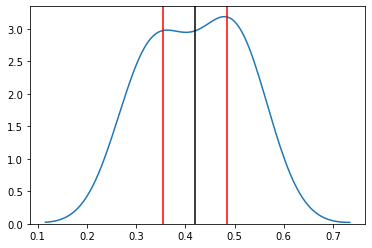


Compared to the actual vote (0.41745283018867924) the random samples t-test results in:
t Statistic: 0.08765412473356538 p-value: 0.9320709194521144

-----

Issue - el-salvador-aid: Confidence Interval:
0.4133650231798686 => Mean: 0.485 => 0.5566349768201314



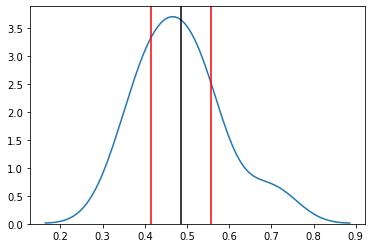


Compared to the actual vote (0.5047619047619047) the random samples t-test results in:
t Statistic: -0.624060150375938 p-value: 0.5480779419070572

-----

Issue - religious-groups: Confidence Interval:
0.6131014432291333 => Mean: 0.69 => 0.7668985567708666



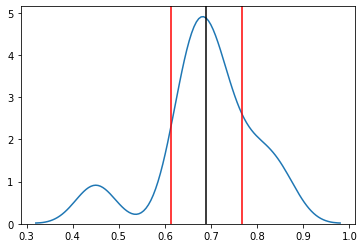


Compared to the actual vote (0.6415094339622641) the random samples t-test results in:
t Statistic: 1.4264673602975453 p-value: 0.18748773995832596

-----

Issue - anti-satellite-ban: Confidence Interval:
0.5296758089935736 => Mean: 0.59 => 0.6503241910064264



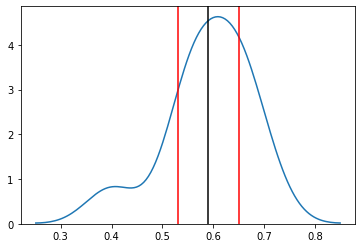


Compared to the actual vote (0.5676959619952494) the random samples t-test results in:
t Statistic: 0.836401425178146 p-value: 0.424578861803499

-----

Issue - aid-to-contras: Confidence Interval:
0.5023655551054473 => Mean: 0.58 => 0.6576344448945526



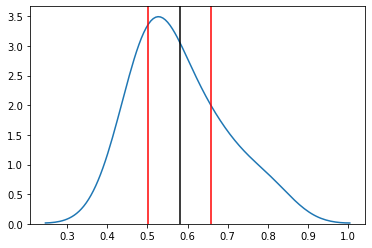


Compared to the actual vote (0.5761904761904761) the random samples t-test results in:
t Statistic: 0.11100409855511291 p-value: 0.9140491592329492

-----

Issue - mx-missile: Confidence Interval:
0.4216268993361128 => Mean: 0.505 => 0.5883731006638873



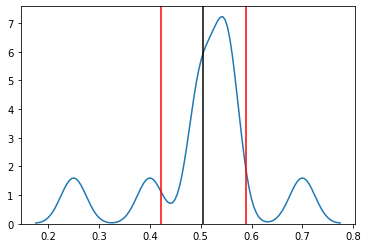


Compared to the actual vote (0.5012106537530266) the random samples t-test results in:
t Statistic: 0.10281609639605797 p-value: 0.9203634045626728

-----

Issue - immigration: Confidence Interval:
0.4266136424317811 => Mean: 0.495 => 0.5633863575682189



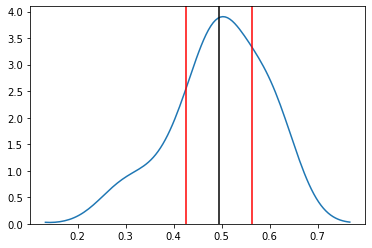


Compared to the actual vote (0.5046728971962616) the random samples t-test results in:
t Statistic: -0.31997045105308447 p-value: 0.7562939863809861

-----

Issue - synfuels: Confidence Interval:
0.3059865948072785 => Mean: 0.355 => 0.40401340519272144



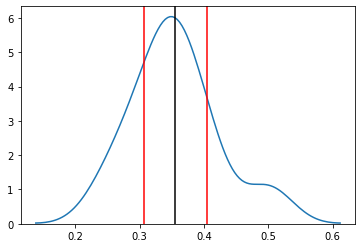


Compared to the actual vote (0.36231884057971014) the random samples t-test results in:
t Statistic: -0.33779264214046645 p-value: 0.7432648677777477

-----

Issue - education: Confidence Interval:
0.36426323688803547 => Mean: 0.43 => 0.4957367631119645



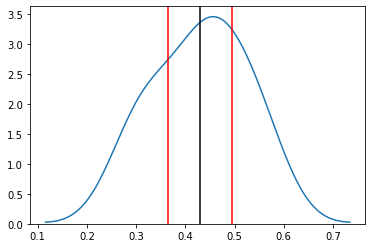


Compared to the actual vote (0.42326732673267325) the random samples t-test results in:
t Statistic: 0.23168717678017142 p-value: 0.8219629392522206

-----

Issue - right-to-sue: Confidence Interval:
0.44369475947473225 => Mean: 0.53 => 0.6163052405252678



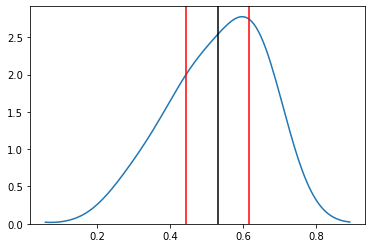


Compared to the actual vote (0.5097560975609756) the random samples t-test results in:
t Statistic: 0.5306153905087772 p-value: 0.6085272062714715

-----

Issue - crime: Confidence Interval:
0.530479804895753 => Mean: 0.6 => 0.669520195104247



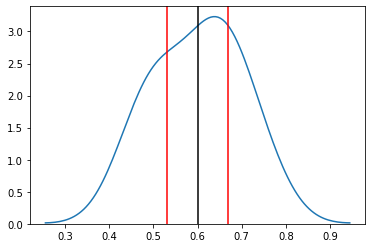


Compared to the actual vote (0.5933014354066986) the random samples t-test results in:
t Statistic: 0.2179684025929078 p-value: 0.8323155734561019

-----

Issue - duty-free: Confidence Interval:
0.3386124463987739 => Mean: 0.425 => 0.5113875536012261



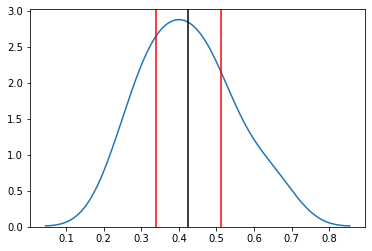


Compared to the actual vote (0.4275184275184275) the random samples t-test results in:
t Statistic: -0.06594791277402211 p-value: 0.9488609997372146

-----

Issue - south-africa: Confidence Interval:
0.7545886923330244 => Mean: 0.8099999999999999 => 0.8654113076669755



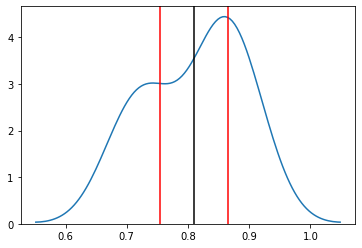


Compared to the actual vote (0.8126888217522659) the random samples t-test results in:
t Statistic: -0.10977068837246119 p-value: 0.9149999178237306

-----


In [197]:
# Iterate through each issue and output its confidence interval and plot
for idx, row in df_issue_CIs.iterrows():
  print(f'\nIssue - {row["Issue"]}: Confidence Interval:\n{row["LowerBound"]} => Mean: {row["Mean"]} => {row["UpperBound"]}\n')

  # Grab the sample means
  lst_smp_means = []
  for i in range(1, num_samples+1):
    lst_smp_means.append(row[int(i)])

  sns.kdeplot(lst_smp_means)
  plt.axvline(x=row["LowerBound"], color='red')
  plt.axvline(x=row["UpperBound"], color='red')
  plt.axvline(x=row["Mean"], color='k')
  plt.show();

  # Conduct a 1 sample t-test of the sample means to the known vote
  t_rslt = ttest_1samp(lst_smp_means, dct_vote_means[row["Issue"]])

  print(f'\nCompared to the actual vote ({dct_vote_means[row["Issue"]]}) the random samples t-test results in:\nt Statistic: {t_rslt.statistic} p-value: {t_rslt.pvalue}\n')

  print("-----")


## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)